In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline

plt.style.use('default') # Make the graphs a bit prettier

plt.rcParams['figure.figsize'] = (12, 4)

In [2]:
#pip install -U statsmodels
import statsmodels.api as sm 

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#  Preprocesamiento de Datos

El analisis exploratorio que se presenta a continuacion tiene como fin determinar que feathers influyen en mayor medida a la hora de determinar el precio de un inmueble en Capital Federal y Gran Buenos Aires, asi como tambien encontrar datos curiosos en el data set.

Los datos fueron provistos por [Properati](http://www.properati.com.ar) y reorganizo en un solo dataset de la siguiente manera : [GitHub | properati_argentina](https://github.com/BraianVicente/properati_argentina/blob/master/src/TP1%20-%20Properati%20-%20Parseo%20de%20datos%20por%20fecha.ipynb)

In [3]:
sell_properati = pd.read_csv('../data/properati_full_month.csv',low_memory=False)

Transformando el formato del feature created_on para manejarlo como fecha

In [4]:
sell_properati['created_on'] = sell_properati['created_on'].apply(lambda x : pd.to_datetime(x))

In [5]:
sell_properati['year'] = sell_properati['created_on'].apply(lambda x : x.year)

In [6]:
def parse_year_month(date):
    if len(str(date.month)) == 1 :
        return str(date.year) + '-0' + str(date.month)
    return str(date.year) + '-' + str(date.month) 

In [7]:
sell_properati['year_month'] = sell_properati.created_on.apply(parse_year_month)

Completamos la columna 'state_name'

In [8]:
sell_properati['state_name'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[2])

Filtramos unicamente los que nos interesan que corresponde a capital federal y alrededores

In [9]:
sell_properati = sell_properati[
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Norte' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Sur' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Oeste' ) |
    (sell_properati['state_name'] == 'Capital Federal' ) 
    ]

In [10]:
sell_properati['zone'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[3])

Filtramos por los datos que son reelevantes para nuestro analisis, obteniendo unicamente las propiedades de GBA y capital federal

In [11]:
sell_properati.drop(inplace=True,\
    labels=['country_name','description','extra','id', u'image_thumbnail','operation'\
            ,'place_with_parent_names_l1','place_with_parent_names_l2', 'properati_url','surface_in_m2','title',\
           ],axis=1)

Podemos seguir trabajando con los datos que no cuentan con la informacion de Zona utilizando la ubicacion para identificarlos segun el barrio al que pertenecen pero en esta ocacion decidimos dejarlos de lado pues no son una cantidad significativa de datos

#### Las propiedades del tigre son las unicas que no contienen informacion en 'place_name'

In [12]:
sell_properati.loc[pd.isnull(sell_properati['place_name']),'place_name'] = sell_properati.place_name.apply(lambda x : x if pd.notnull(x) else 'Tigre' )

In [13]:
sell_properati = sell_properati[sell_properati['zone'] != '']

In [14]:
#Calcula el precio la incognita (incognita = divisor/dividendo) para todo divisor mayor a cero y todo dividendo mayor a cero.

def dataframe_calc_value(df,incognita,divisor,dividendo):
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0)) ,incognita] = \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][divisor] / \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][dividendo]

# Continuaremos trabajando con el set de datos completo para disponer de toda la informacion.

### Se agrega la superficie total de los inmbuebles que disponen del precio por metro cuadrado en dolares


In [15]:
sell_properati_filter = sell_properati

In [16]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price_aprox_usd','price_usd_per_m2')

### Calculamos la superficie total en metros cuadrados de las propiedades que no cuentan con este dato

In [17]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price','price_per_m2')

### Calculamos el precio por metro cuadrado en USD de los inmuebles que no cuentan con dicha informacion

In [18]:
dataframe_calc_value(sell_properati_filter,'price_usd_per_m2','price_aprox_usd','surface_total_in_m2')

### Se agrega el precio por metro cuadrado en la moneda actual en cada unos de las pripiedades

In [19]:
dataframe_calc_value(sell_properati_filter,'price_per_m2','price','surface_total_in_m2')

In [20]:
sell_properati_filter = sell_properati_filter[~((sell_properati_filter['surface_total_in_m2'] == 0 ) | \
                     (sell_properati_filter['price'] == 0 ))]

In [21]:
sell_properati_filter[['surface_total_in_m2','price_usd_per_m2','price_per_m2']].mean()

surface_total_in_m2    7402.093163
price_usd_per_m2       2268.710530
price_per_m2           3892.322905
dtype: float64

In [22]:
sell_properati_filter[(pd.notnull(sell_properati_filter['surface_total_in_m2']))]\
            [['surface_total_in_m2','price_usd_per_m2','price_per_m2','price_aprox_usd','price']].shape

(278094, 5)

Filtraremos los datos que tengan una superficie total en metros cuadrados entre 0 y 1000

In [23]:
filter_properati = sell_properati_filter[(sell_properati_filter['price_aprox_usd'] < 600000) &\
                                         (sell_properati_filter['price_usd_per_m2'] < 5000) & \
                                         (sell_properati_filter['surface_total_in_m2'] < 1000)]

In [24]:
float(filter_properati.shape[0]) / float(sell_properati.shape[0]) * 100

62.02927539329903

In [25]:
filter_properati.columns

Index([u'created_on', u'currency', u'expenses', u'floor', u'geonames_id',
       u'lat', u'lat-lon', u'lon', u'place_name', u'place_with_parent_names',
       u'price', u'price_aprox_local_currency', u'price_aprox_usd',
       u'price_per_m2', u'price_usd_per_m2', u'property_type', u'rooms',
       u'state_name', u'surface_covered_in_m2', u'surface_total_in_m2',
       u'year', u'year_month', u'zone'],
      dtype='object')

In [26]:
pd.DataFrame(data=sell_properati.state_name.unique(),columns=['states'])

,states
0,Bs.As. G.B.A. Zona Sur
1,Capital Federal
2,Bs.As. G.B.A. Zona Oeste
3,Bs.As. G.B.A. Zona Norte


In [27]:
df = pd.DataFrame(data=sell_properati.place_name.unique(),columns=['place_name']).reset_index()


In [28]:
df.rename(columns={'index':'id_place_name'},inplace=True)

In [29]:
filter_properati = filter_properati.merge(how='left',left_on='place_name',right_on='place_name',right=df)

In [30]:
df = pd.DataFrame(data=sell_properati.state_name.unique(),columns=['states']).reset_index()
df.rename(columns={'index':'id_states'},inplace=True)

In [31]:
filter_properati = filter_properati.merge(how='left',left_on='state_name',right_on='states',right=df)

In [32]:
filter_properati.created_on = filter_properati.created_on.astype(int)

In [33]:
df = pd.DataFrame(data=sell_properati.property_type.unique(),columns=['property_type']).reset_index()
df.rename(columns={'index':'id_property_type'},inplace=True)

In [34]:
filter_properati = filter_properati.merge(how='left',left_on='property_type',right_on='property_type',right=df)

In [35]:
filter_properati.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243749 entries, 0 to 243748
Data columns (total 27 columns):
created_on                    243749 non-null int64
currency                      243749 non-null object
expenses                      19623 non-null object
floor                         47217 non-null float64
geonames_id                   199847 non-null float64
lat                           192128 non-null float64
lat-lon                       192128 non-null object
lon                           192123 non-null float64
place_name                    243749 non-null object
place_with_parent_names       243749 non-null object
price                         243749 non-null float64
price_aprox_local_currency    243749 non-null float64
price_aprox_usd               243749 non-null float64
price_per_m2                  243749 non-null float64
price_usd_per_m2              243749 non-null float64
property_type                 243749 non-null object
rooms                         16043

In [36]:
filter_properati.columns

Index([u'created_on', u'currency', u'expenses', u'floor', u'geonames_id',
       u'lat', u'lat-lon', u'lon', u'place_name', u'place_with_parent_names',
       u'price', u'price_aprox_local_currency', u'price_aprox_usd',
       u'price_per_m2', u'price_usd_per_m2', u'property_type', u'rooms',
       u'state_name', u'surface_covered_in_m2', u'surface_total_in_m2',
       u'year', u'year_month', u'zone', u'id_place_name', u'id_states',
       u'states', u'id_property_type'],
      dtype='object')

In [37]:
data = filter_properati.drop(axis=1,labels=['currency','lat','lat-lon','lon','place_name','place_with_parent_names','price'\
                                            ,'price_aprox_local_currency','price_per_m2','price_usd_per_m2','property_type','state_name'\
                                            ,'surface_covered_in_m2','year','year_month','zone','states'])

In [38]:
import re

def devolverInt(x):
    return float(re.search(r'\d+', x).group())

In [39]:
data['geonames_id'] = data.geonames_id.apply(lambda x : 0 if pd.isnull(x) else x )

In [40]:
data['expenses'] = data.expenses.apply(lambda x : devolverInt(x) if pd.notnull(x) else 0 )

In [41]:
data['floor'] = data.floor.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [42]:
data['price_aprox_usd'] = data.price_aprox_usd.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [43]:
data['rooms'] = data.rooms.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [44]:
data['surface_total_in_m2'] = data.surface_total_in_m2.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243749 entries, 0 to 243748
Data columns (total 10 columns):
created_on             243749 non-null int64
expenses               243749 non-null float64
floor                  243749 non-null float64
geonames_id            243749 non-null float64
price_aprox_usd        243749 non-null float64
rooms                  243749 non-null float64
surface_total_in_m2    243749 non-null float64
id_place_name          243749 non-null int64
id_states              243749 non-null int64
id_property_type       243749 non-null int64
dtypes: float64(6), int64(4)
memory usage: 20.5 MB


In [46]:
data.tail()

,created_on,expenses,floor,geonames_id,price_aprox_usd,rooms,surface_total_in_m2,id_place_name,id_states,id_property_type
243744,1393545600000000000,0.0,0.0,3427753.0,130000.0,1.0,49.0,15,3,1
243745,1393545600000000000,0.0,0.0,3427753.0,160000.0,4.0,203.0,15,3,0
243746,1393545600000000000,0.0,0.0,3430550.0,65000.0,2.0,120.0,61,2,0
243747,1393545600000000000,8600.0,0.0,3436109.0,550000.0,3.0,324.0,31,1,1
243748,1393545600000000000,0.0,1.0,3429979.0,450000.0,3.0,268.0,22,3,0


# Normalizacion de datos

In [47]:
train = data.head(int(float(data.shape[0]) * 0.8)).copy()

In [48]:
train_target = train[['price_aprox_usd']].copy()

In [49]:
train.drop(inplace=True,labels=['price_aprox_usd'],axis=1)

In [50]:
test = data.tail(int(float(data.shape[0]) * 0.2)).copy()

In [51]:
test_target = test[['price_aprox_usd']].copy()

In [52]:
test.drop(inplace=True,labels=['price_aprox_usd'],axis=1)

In [53]:
for col in train.columns :
    col_mean = train[col].mean()
    col_std = train[col].std()
    train[col] = (train[col] - col_mean) / col_std

In [54]:
for col in test.columns :
    col_mean = test[col].mean()
    col_std = test[col].std()
    test[col] = (test[col] - col_mean) / col_std

# Reduccion de Dimensiones

In [55]:
from sklearn import decomposition

In [56]:
svd = decomposition.TruncatedSVD(n_components=train.shape[1]-1)

In [57]:
train_transform = svd.fit_transform(train)

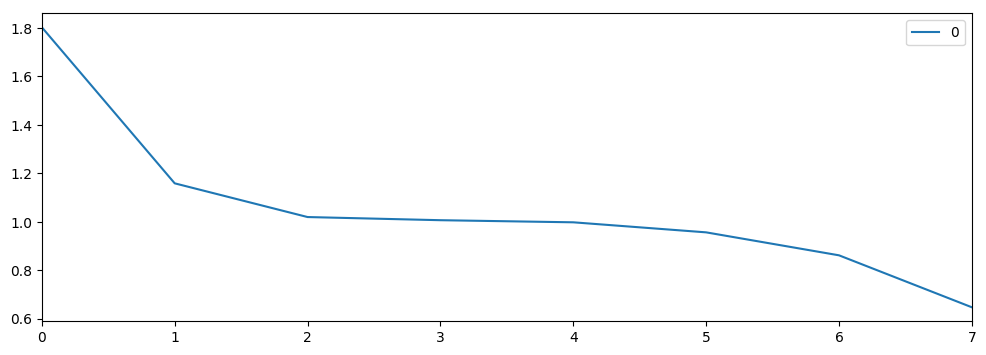

In [58]:
pd.DataFrame(svd.explained_variance_).plot()

In [59]:
test_transform = svd.transform(test)

In [60]:
test = pd.DataFrame(test_transform)

In [61]:
train = pd.DataFrame(train_transform)

# Machine Learning


In [62]:
from sklearn import neighbors

In [63]:
msqDF = pd.DataFrame(columns={'k_Neighbors','p_minkowski','mean_squear_error'})

In [64]:
for k in xrange(200,200+2000) :
    print k
    for p in xrange(2,1+2):
        knn = neighbors.KNeighborsRegressor(n_neighbors=k,n_jobs=-1,p=p)
        knn.fit(train,train_target)
        test_prediction = knn.predict(test)
        msq_knn = mean_squared_error(test_prediction, test_target)
        msqDF = msqDF.append( pd.DataFrame(data={'k_Neighbors' : [k],'p_minkowski' : [p] ,'mean_squear_error' :[msq_knn]}) )

200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449


In [65]:
msqDF.describe()

,mean_squear_error
count,2.000000e+03
mean,6.810968e+09
std,1.436005e+08
min,6.569238e+09
25%,6.692235e+09
50%,6.821515e+09
75%,6.933526e+09
max,7.049668e+09


In [66]:
msqDF

,k_Neighbors,mean_squear_error,p_minkowski
0,200,6.635044e+09,2
0,201,6.634227e+09,2
0,202,6.632325e+09,2
0,203,6.630790e+09,2
0,204,6.629901e+09,2
0,205,6.629350e+09,2
0,206,6.628516e+09,2
0,207,6.627508e+09,2
0,208,6.626683e+09,2
0,209,6.625425e+09,2


In [67]:
msqDF[msqDF['mean_squear_error'] == msqDF.mean_squear_error.min()]

,k_Neighbors,mean_squear_error,p_minkowski
0,302,6.569238e+09,2


In [69]:
msqDF.k_Neighbors = msqDF.k_Neighbors.astype(float)

In [70]:
msqDF.mean_squear_error = msqDF.mean_squear_error.astype(float)

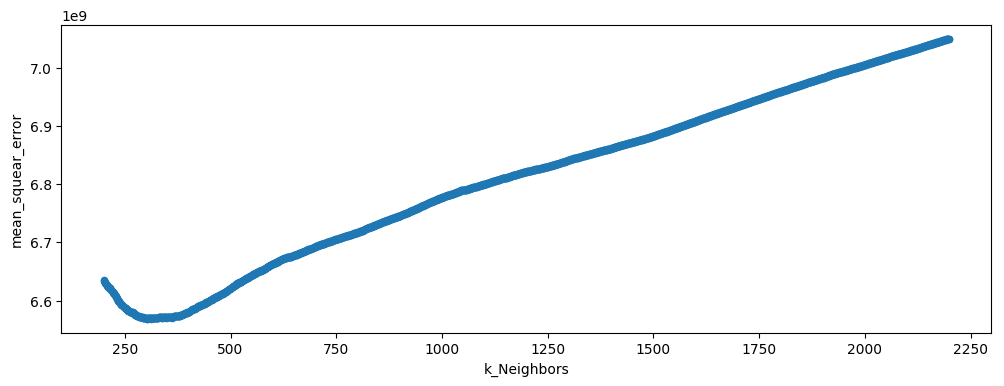

In [71]:
msqDF.plot.scatter(x='k_Neighbors',y='mean_squear_error')

msqDF[msqDF.p_minkowski == 2 ].sort_index(by='mean_squear_error',ascending=True).head(200)

###  Se llega la conclusion de que con un.....

for k in xrange(1,1+2000) :
    print k
    for p in xrange(2,1+2):
        knn = neighbors.KNeighborsRegressor(n_neighbors=k,n_jobs=-1,p=p)
        knn.fit(train,train_target)
        test_prediction = knn.predict(test)
        msq_knn = mean_squared_error(test_prediction, test_target)
        msqDF = msqDF.append( pd.DataFrame(data={'k-Neighbors' : [k],'p_minkowski' : [p] ,'mean_squear_error' :[msq_knn]}) )

msqDF[msqDF.p_minkowski == 2 ].sort_index(by='mean_squear_error',ascending=True).head(20)

knn = neighbors.KNeighborsRegressor(n_neighbors=2000,n_jobs=-1,p=2)
knn.fit(train,train_target)
test_prediction = knn.predict(test)
msq_knn = mean_squared_error(test_prediction, test_target)
msqDF = msqDF.append( pd.DataFrame(data={'k-Neighbors' : [2000],'p_minkowski' : [2] ,'mean_squear_error' :[msq_knn]}) )

msqDF[msqDF.p_minkowski == 2 ].sort_index(by='mean_squear_error',ascending=True).head(20)

msqDF.rename(columns={'k-Neighbors':'k_Neighbors'},inplace=True)

msqDF.k_Neighbors = msqDF.k_Neighbors.astype(int)

msqDF.plot.scatter(x='k_Neighbors',y='mean_squear_error')

for k in xrange(200,201+1800) :
    print k
    for p in xrange(2,1+3):
        knn = neighbors.KNeighborsRegressor(n_neighbors=k,n_jobs=-1,p=p)
        knn.fit(train,train_target)
        test_prediction = knn.predict(test)
        msq_knn = mean_squared_error(test_prediction, test_target)
        msqDF = msqDF.append( pd.DataFrame(data={'k_Neighbors' : [k],'p_minkowski' : [p] ,'mean_squear_error' :[msq_knn]}) )

msqDF.plot.scatter(x='k_Neighbors',y='mean_squear_error')